## ETH wallet tracked compared to USD price

##### I get history of balance from 5th bigest ETH wallet. 

**I would like to see how his wallet perform from first to last transaction**

**Note:**  At this point my data only includes value of wallet when transaction is done. I mean that If I wont to compare this wallet to USD price I need value of wallet in every single day. 

**Goal:** I will rerange datetime index to full days and copy last registered state of wallet. for eg.: 01.05.2020 wallet values was 1,000,000 ETH and after that date next transaction has been done in 01.06.2020 I will fill missing dates with value of 1,000,000 ETH till the first existed transaction

In [64]:
import pandas as pd
import seaborn as sb
sb.set()
from datetime import datetime, timedelta
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
import warnings

warnings.filterwarnings("ignore")

In [65]:
df = pd.read_csv('Data/HistoryOfWallet2.csv', usecols=['date', 'balance'])

In [66]:
df['balance'] = round(df['balance'],3)

In [67]:
df['date'] = pd.to_datetime(df['date'])

In [68]:
df['date'] = df['date'].apply( lambda x : x.strftime("%Y-%m-%d"))

In [69]:
start = df['date'][0]
end = df['date'][len(df)-1]

### Let's prepare the data for feature analysis

<AxesSubplot:xlabel='date'>

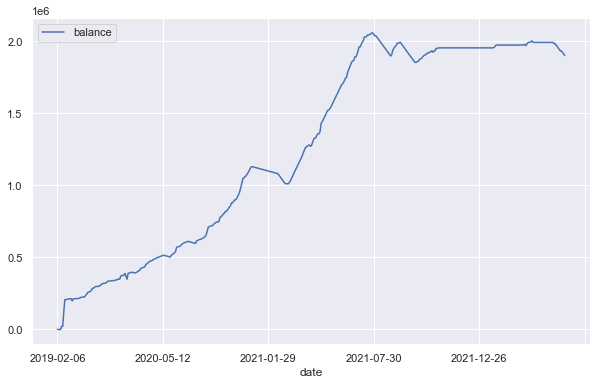

In [70]:
df.plot(x='date', y='balance')

Current df show the value of wallet only in trading days. I want to check the ETH/USD amount of wallet for evry single day, so I need to create a new datetime column and duplicate wallet amount till it has been changed in trading day

In [71]:
# Sometimes is few transaction a day, so to be fair we take the last wallet amount any trading day
df = df.groupby('date').last()

In [72]:
# Function to insert row in the dataframe
def Insert_row_(row_number, df, row_value):
    
    # Slice above rows
    df1 = df[0:row_number]
  
    # Store below rows
    df2 = df[row_number:]
  
    # Insert the row in the upper half dataframe
    df1.loc[row_number]=row_value
  
    # Concat the two dataframes
    df_result = pd.concat([df1, df2])
  
    # Reassign the index labels
    df_result.index = [*range(df_result.shape[0])]
  
    # Return the updated dataframe
    return df_result

In [73]:
full_df = pd.DataFrame({"dates":pd.date_range(start=start, end=end)})

In [74]:
len(full_df)

1172

In [75]:
df.reset_index(inplace=True)

In [76]:
# We must set date as datetime agin becouse of grouping by
df['date'] = pd.to_datetime(df['date'])

In [77]:
missing_dates = pd.date_range(start=start, end=end).difference(df['date'])
missing_frame = pd.DataFrame({'missing_dates':missing_dates})

In [78]:
missing_dates

DatetimeIndex(['2019-02-07', '2019-02-08', '2019-02-09', '2019-02-15',
               '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21',
               ...
               '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14',
               '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-18',
               '2022-04-19', '2022-04-21'],
              dtype='datetime64[ns]', length=887, freq=None)

In [79]:
for i in range(1, len(full_df)):
    
    if (df['date'].loc[i] - df['date'].loc[i-1]).days > 1:
        row_number = i # first [0]+1 = 1
        row_value = [full_df['dates'].iloc[i-1], df['balance'].iloc[i-1]]
        if row_number > df.index.max()+1:
            print("Invalid row_number")
        else:

            # Let's call the function and insert the row
            # at the second position
            df = Insert_row_(row_number, df, row_value)
            df = df.sort_values(by="date")
    else:
        df = df.sort_values(by="date")

In [80]:
len(df)

1173

In [81]:
df

,date,balance
0,2019-02-06,0.050
1,2019-02-06,0.050
2,2019-02-07,0.050
3,2019-02-08,0.050
4,2019-02-09,0.050
...,...,...
1168,2022-04-18,1923504.539
1169,2022-04-19,1923504.539
1170,2022-04-20,1913504.534
1171,2022-04-21,1913504.534


In [82]:
# We must cut first row becouse it was reapited
df = df.iloc[1: , :]

### Now lets chceck the value of ETH/USD from time when owner bought ETH for the first time

In [83]:
import pandas_datareader.data as reader

In [84]:
base_currency = 'USD'

In [85]:
eth_usd = reader.get_data_yahoo([f'ETH-{base_currency}'], start=start, end=pd.to_datetime(end) - timedelta(days=0))['Adj Close']

In [86]:
eth_usd.reset_index(inplace=True)

In [87]:
df['eth_usd'] = eth_usd['ETH-USD']

In [88]:
df['wallet_value_in_USD'] = df['balance'] * df['eth_usd']

In [89]:
df.set_index('date', inplace = True)

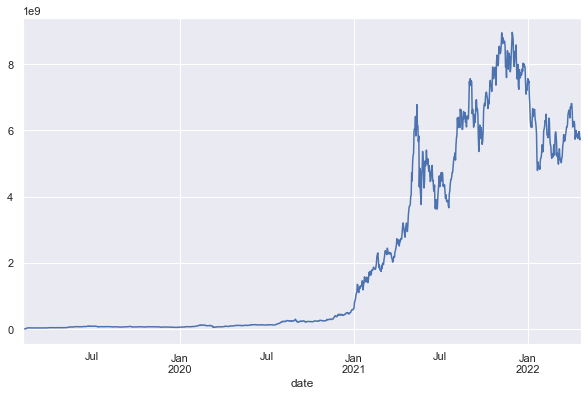

In [90]:
df['wallet_value_in_USD'].plot();

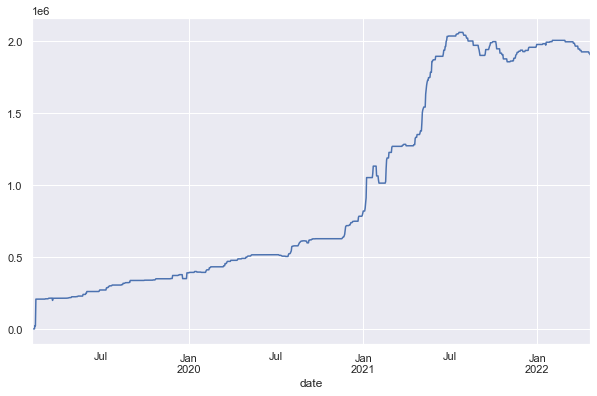

In [91]:
df['balance'].plot();

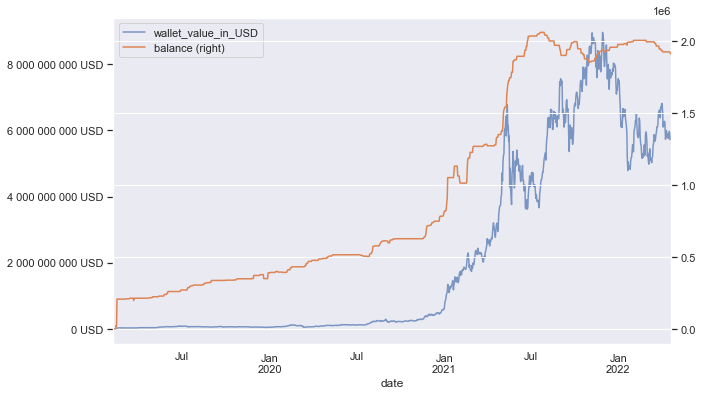

In [109]:
fig, ax = plt.subplots()

df.reset_index().plot(x = 'date', y = 'wallet_value_in_USD', ax = ax, alpha=0.7)

df.reset_index().plot(x = 'date', y = 'balance', ax = ax, secondary_y = True)

y_value=['{:,.0f}'.format(x).replace(",", " ") + ' USD' for x in ax.get_yticks()]
ax.set_yticklabels(y_value);

Now we can see how wallet perform in respect of USD price. 

In [17]:
# from polygon import RESTClient
# client = RESTClient('NWVvj9kpjavSP45li34lMGZNCex2rPy8')
# response = client.crypto_aggregates('X:ETHUSD', multiplier =1, timespan='day', from_=start, to=end, sort='asc')
# ETH_USD = pd.DataFrame(response.results)[['o', 'c', 't']]
# ETH_USD['t'] = pd.to_datetime(ETH_USD['t'], unit='ms')

The problem with polygon is that it contains data only from 2020-03-08, and in our perpous it is not enought